In [1]:
import yfinance as yf
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

from statsmodels.tsa.arima.model import ARIMA
from math import sqrt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from pmdarima import auto_arima
from datetime import timedelta

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout, Concatenate
import math
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Define the ticker symbol for S&P 500 Index
tickerSymbol = '^GSPC'

# Get data on this ticker
tickerData = yf.Ticker(tickerSymbol)

# Get the historical prices for this ticker
tickerDf = tickerData.history(period='1d', start='2010-1-1', end='2023-9-30')

# Convert the index (date) to a datetime object
tickerDf.index = pd.to_datetime(tickerDf.index)

# Modify the "Date" column to include only the date in 'YYYY-MM-DD' format
tickerDf['Date'] = tickerDf.index.strftime('%Y-%m-%d')

In [3]:
# Convert the output into a Pandas DataFrame
stock_Data = pd.DataFrame(tickerDf)
# Convert the 'Date' column to datetime if it's not already
stock_Data['Date'] = pd.to_datetime(stock_Data['Date'])
stock_Data.head(10)

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Date
Date,,,,,,,,
2010-01-04 00:00:00-05:00,1116.560059,1133.869995,1116.560059,1132.989990,3991400000,0.0,0.0,2010-01-04
2010-01-05 00:00:00-05:00,1132.660034,1136.630005,1129.660034,1136.520020,2491020000,0.0,0.0,2010-01-05
2010-01-06 00:00:00-05:00,1135.709961,1139.189941,1133.949951,1137.140015,4972660000,0.0,0.0,2010-01-06
2010-01-07 00:00:00-05:00,1136.270020,1142.459961,1131.319946,1141.689941,5270680000,0.0,0.0,2010-01-07
2010-01-08 00:00:00-05:00,1140.520020,1145.390015,1136.219971,1144.979980,4389590000,0.0,0.0,2010-01-08
2010-01-11 00:00:00-05:00,1145.959961,1149.739990,1142.020020,1146.979980,4255780000,0.0,0.0,2010-01-11
2010-01-12 00:00:00-05:00,1143.810059,1143.810059,1131.770020,1136.219971,4716160000,0.0,0.0,2010-01-12
2010-01-13 00:00:00-05:00,1137.310059,1148.400024,1133.180054,1145.680054,4170360000,0.0,0.0,2010-01-13
2010-01-14 00:00:00-05:00,1145.680054,1150.410034,1143.800049,1148.459961,3915200000,0.0,0.0,2010-01-14


In [4]:
stock_Data.drop(columns=['Dividends', 'Stock Splits'], inplace=True)
stock_Data.describe().round(2)

,Open,High,Low,Close,Volume
count,3459.00,3459.00,3459.00,3459.00,3.459000e+03
mean,2499.48,2513.18,2484.74,2499.94,3.941686e+09
std,1047.48,1053.78,1040.76,1047.45,9.639961e+08
min,1027.65,1032.95,1010.91,1022.58,1.025000e+09
25%,1633.62,1642.79,1627.10,1633.73,3.359390e+09
50%,2185.17,2188.06,2179.42,2186.48,3.778950e+09
75%,3159.57,3183.41,3141.14,3168.69,4.321095e+09
max,4804.51,4818.62,4780.04,4796.56,1.061781e+10


# Temporal Analysis

In [5]:
# Extract year, month, and day
stock_Data['Year']   = stock_Data['Date'].dt.year
stock_Data['Month']  = stock_Data['Date'].dt.month
stock_Data['Day']    = stock_Data['Date'].dt.day

# Extract the date only from the 'Date' column
stock_Data['Date'] = stock_Data['Date'].dt.date

# Reset the index of the DataFrame
stock_Data.reset_index(drop=True, inplace=True)

In [6]:
# Convert 'Date' to datetime if it's not already
stock_Data['Date'] = pd.to_datetime(stock_Data['Date'])

stack_copy = stock_Data.copy()
# Set 'Date' as the index of the DataFrame
stack_copy.set_index('Date', inplace=True)

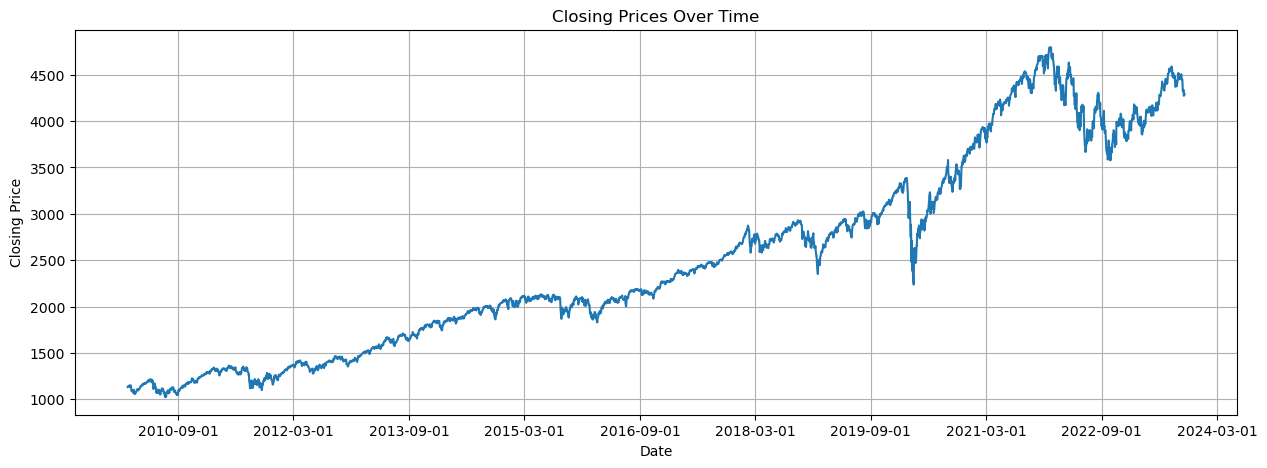

In [7]:
# Plot 'Close' column
plt.figure(figsize=(15,5))
plt.plot(stack_copy['Close'])

# Set x-axis major ticks format
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=18))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

plt.title('Closing Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.grid(True)
plt.show()

<Axes: >

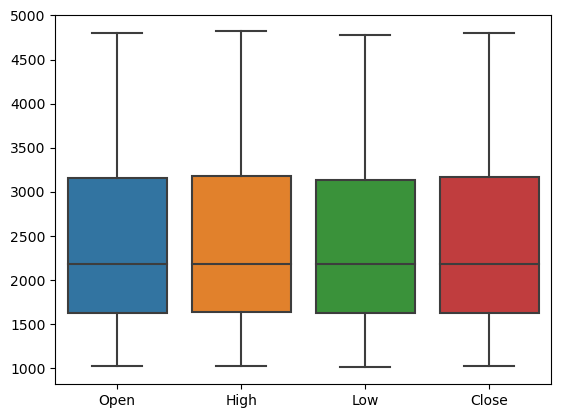

In [8]:
sns.boxplot(data=stack_copy[['Open', 'High', 'Low', 'Close']])

# Check Seasonality 

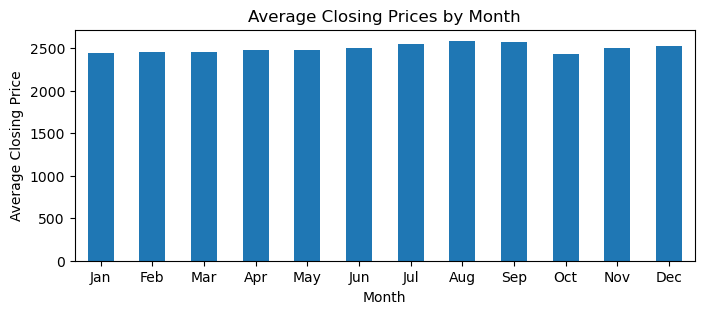

In [9]:
# Group by 'Month' and calculate the average of 'Close' prices
monthly_data = stack_copy.groupby('Month')['Close'].mean()

# Plot the average 'Close' prices by month
plt.figure(figsize=(8, 3))
monthly_data.plot(kind='bar')
plt.title('Average Closing Prices by Month')
plt.xlabel('Month')
plt.ylabel('Average Closing Price')
plt.xticks(range(12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], rotation=0)
plt.show()

# Distribution of Data

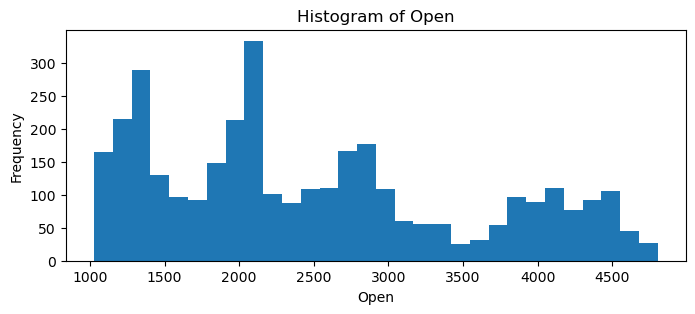

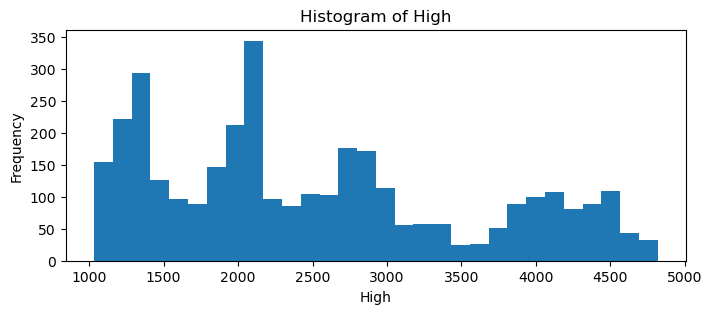

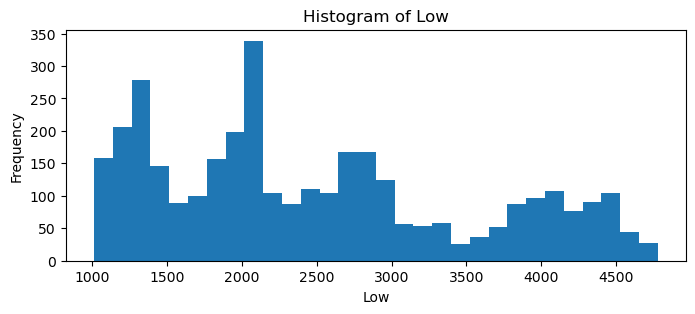

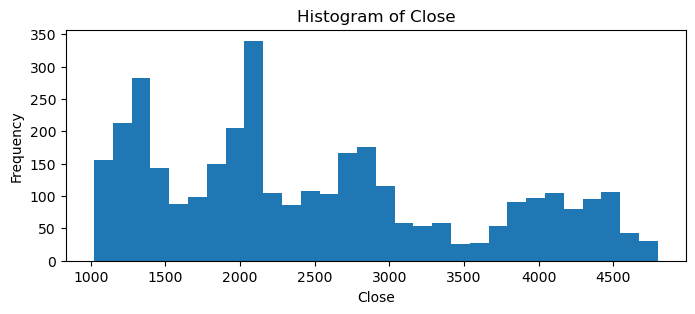

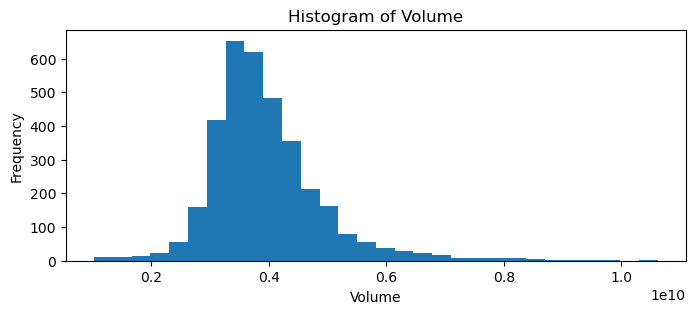

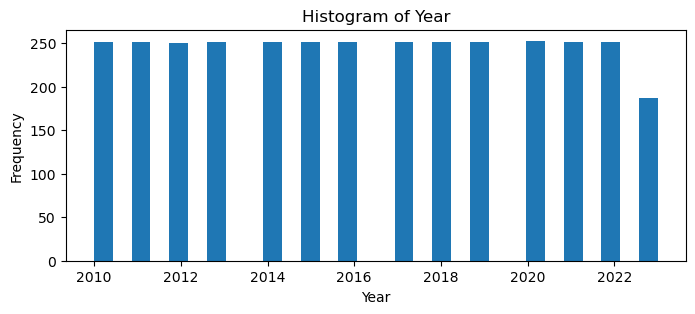

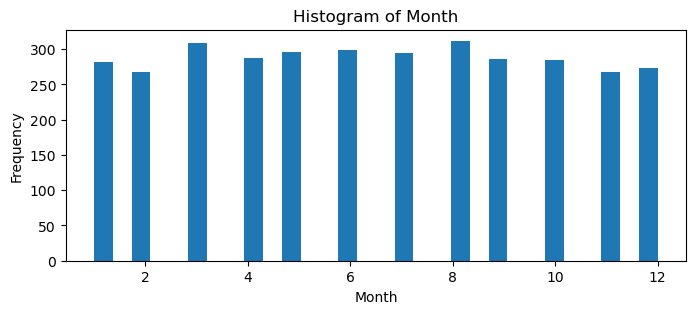

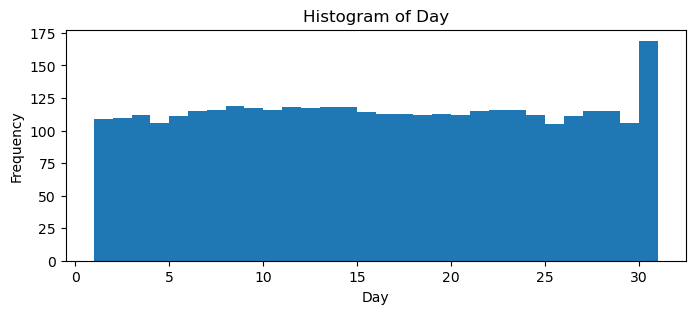

In [10]:
for column in stack_copy.columns:
    plt.figure(figsize=(8, 3))
    plt.hist(stock_Data[column], bins=30)
    plt.title(f'Histogram of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.show()

# Data Preprocessing

In [11]:
stock_Data.drop(columns=['Year', 'Month', 'Day'], inplace=True)
stock_Data.set_index('Date', inplace=True)
stock_Data.head()

,Open,High,Low,Close,Volume
Date,,,,,
2010-01-04,1116.560059,1133.869995,1116.560059,1132.989990,3991400000
2010-01-05,1132.660034,1136.630005,1129.660034,1136.520020,2491020000
2010-01-06,1135.709961,1139.189941,1133.949951,1137.140015,4972660000
2010-01-07,1136.270020,1142.459961,1131.319946,1141.689941,5270680000
2010-01-08,1140.520020,1145.390015,1136.219971,1144.979980,4389590000


# Data Splitting

In [13]:
# Define the percentage for training data
train_percentage = 0.8

# Calculate the index for splitting the data
split_index = int(len(stock_Data) * train_percentage)

# Split the data into training and testing sets
train_data = stock_Data.iloc[:split_index]
test_data = stock_Data.iloc[split_index:]

# Display the number of data points in the training and testing sets
print("Number of data points in the training set:", len(train_data))
print("Number of data points in the testing set:", len(test_data))

Number of data points in the training set: 2767
Number of data points in the testing set: 692


# ARIMA MODEL

In [14]:
# Use auto_arima to determine the best p, d, and q values
autoarima_model = auto_arima(train_data['Close'], seasonal=False, trace=True, error_action='ignore', suppress_warnings=True)

# Get the best order (p, d, q)
best_order = autoarima_model.order

# Create and train the ARIMA model with the best order
arima_model = ARIMA(train_data['Close'], order=best_order)
arima_model_fit = arima_model.fit()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=25477.315, Time=2.28 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=25609.204, Time=0.11 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=25517.366, Time=0.39 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=25536.352, Time=0.74 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=25611.166, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=25478.270, Time=1.44 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=25485.585, Time=0.90 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=25351.906, Time=3.48 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=25397.709, Time=2.84 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=25389.792, Time=4.75 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=25473.012, Time=3.93 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=25472.538, Time=3.05 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=25386.811, Time=2.47 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=25355.524, Time=4.31 sec
 ARIMA(3,1,2)(0,0,0

In [15]:
# Make predictions on the testing data
arima_predictions = arima_model_fit.predict(start=len(train_data), end=len(train_data) + len(test_data) - 1, typ='levels')

# Calculate evaluation metrics
mae_arima = mean_absolute_error(test_data['Close'], arima_predictions)
mse_arima = mean_squared_error(test_data['Close'], arima_predictions)
rmse_arima = np.sqrt(mse_arima)

# Display the best order and evaluation metrics
print("Best ARIMA Order (p, d, q):", best_order)
print("ARIMA Model Evaluation:")
print("Mean Absolute Error (MAE):", mae_arima)
print("Mean Squared Error (MSE):", mse_arima)
print("Root Mean Squared Error (RMSE):", rmse_arima)

Best ARIMA Order (p, d, q): (3, 1, 2)
ARIMA Model Evaluation:
Mean Absolute Error (MAE): 472.4180103646558
Mean Squared Error (MSE): 298165.3447010643
Root Mean Squared Error (RMSE): 546.0451855854644


In [34]:
# Extend the date index to include future dates
last_date = stock_Data.index[-1]
future_dates_10 = [last_date + timedelta(days=i) for i in range(1, 11)]
future_dates_20 = [last_date + timedelta(days=i) for i in range(1, 21)]
future_dates_30 = [last_date + timedelta(days=i) for i in range(1, 31)]

# Make predictions for the next 10, 20, and 30 days
forecast_10 = arima_model_fit.forecast(steps=10)
forecast_20 = arima_model_fit.forecast(steps=20)
forecast_30 = arima_model_fit.forecast(steps=30)

In [43]:
# Create DataFrames for the forecasts
forecast_df_10 = pd.DataFrame({'Predicted_10': forecast_10.values}, index=future_dates_10)
forecast_df_20 = pd.DataFrame({'Predicted_20': forecast_20.values}, index=future_dates_20)
forecast_df_30 = pd.DataFrame({'Predicted_30': forecast_30.values}, index=future_dates_30)

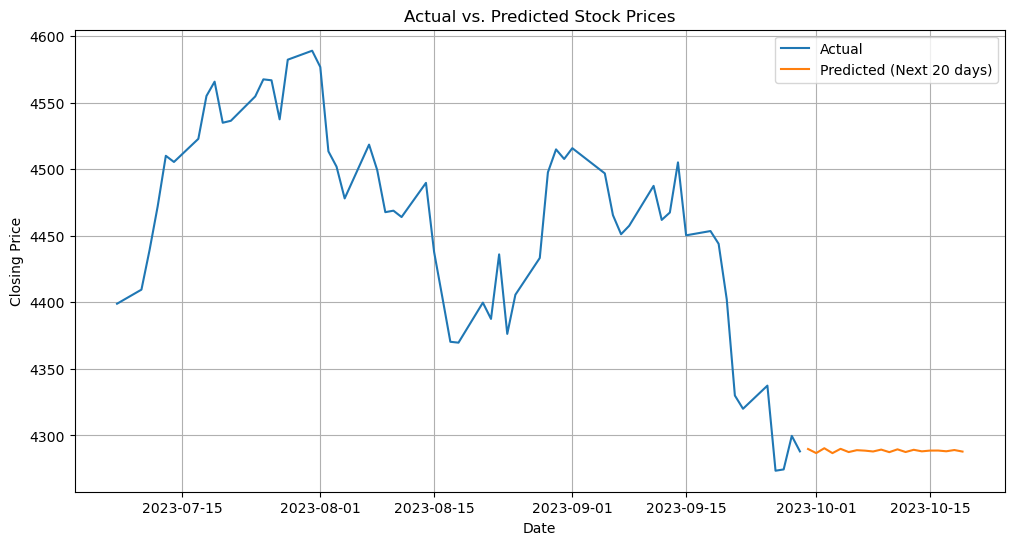

In [47]:
# Plot actual and predicted values for the next 10, 20, and 30 days
plt.figure(figsize=(12, 6))
plt.plot(stock_Data['Close'].tail(60), label='Actual')
plt.plot(forecast_df_20, label='Predicted (Next 20 days)')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('Actual vs. Predicted Stock Prices')
plt.legend()
plt.grid(True)
plt.show()

# LSTM Model

In [59]:
# Define the number of previous days to use for prediction
look_back = 30  # You can adjust this value

# Convert the DataFrame to a numpy array
dataset = stock_Data['Close'].values.reshape(-1, 1)

# Normalize the dataset (scaling values between 0 and 1)
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

# Split the dataset into training and testing sets
train_size = int(len(dataset) * 0.8)
test_size = len(dataset) - train_size
train_data, test_data = dataset[0:train_size, :], dataset[train_size:len(dataset), :]

In [60]:
# Create sequences and labels for the LSTM model
def create_sequences(dataset, look_back):
    X, Y = [], []
    for i in range(len(dataset) - look_back):
        X.append(dataset[i:(i + look_back), 0])
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

train_X, train_Y = create_sequences(train_data, look_back)
test_X, test_Y = create_sequences(test_data, look_back)

# Reshape input data to be [samples, time steps, features]
train_X = np.reshape(train_X, (train_X.shape[0], train_X.shape[1], 1))
test_X = np.reshape(test_X, (test_X.shape[0], test_X.shape[1], 1))

In [62]:
# Create an enhanced LSTM model
model = Sequential()
model.add(LSTM(units=64, return_sequences=True, input_shape=(look_back, 1)))
model.add(LSTM(units=64))
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.2))  # Dropout for regularization
model.add(Dense(units=1))
optimizer = Adam(learning_rate=0.001)
model.compile(loss='mean_squared_error', optimizer=optimizer)

In [64]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)
# Fit the model with enhanced parameters
history = model.fit(
    train_X,
    train_Y,
    epochs=100,             # You can adjust the number of epochs
    batch_size=64,          # Batch size for training
    validation_split=0.1,   # Use a portion of training data for validation
    callbacks=[early_stopping, checkpoint],
    verbose=2
)

Epoch 1/100
39/39 - 8s - loss: 0.0142 - val_loss: 0.0040 - 8s/epoch - 218ms/step
Epoch 2/100
39/39 - 2s - loss: 0.0029 - val_loss: 0.0014 - 2s/epoch - 40ms/step
Epoch 3/100
39/39 - 1s - loss: 0.0025 - val_loss: 0.0018 - 1s/epoch - 38ms/step
Epoch 4/100
39/39 - 1s - loss: 0.0022 - val_loss: 0.0013 - 1s/epoch - 38ms/step
Epoch 5/100
39/39 - 1s - loss: 0.0018 - val_loss: 0.0015 - 1s/epoch - 36ms/step
Epoch 6/100
39/39 - 2s - loss: 0.0018 - val_loss: 0.0012 - 2s/epoch - 46ms/step
Epoch 7/100
39/39 - 2s - loss: 0.0017 - val_loss: 0.0060 - 2s/epoch - 49ms/step
Epoch 8/100
39/39 - 2s - loss: 0.0017 - val_loss: 0.0013 - 2s/epoch - 42ms/step
Epoch 9/100
39/39 - 2s - loss: 0.0017 - val_loss: 0.0012 - 2s/epoch - 42ms/step
Epoch 10/100
39/39 - 2s - loss: 0.0015 - val_loss: 0.0012 - 2s/epoch - 41ms/step
Epoch 11/100
39/39 - 2s - loss: 0.0015 - val_loss: 0.0014 - 2s/epoch - 43ms/step
Epoch 12/100
39/39 - 2s - loss: 0.0014 - val_loss: 0.0012 - 2s/epoch - 40ms/step
Epoch 13/100
39/39 - 2s - loss: 0.00

In [65]:
# Load the best model weights
model.load_weights('best_model.h5')

# Make predictions on the test data
test_predictions = model.predict(test_X)

# Inverse transform the predictions and actual values to the original scale
test_predictions = scaler.inverse_transform(test_predictions)
test_Y = scaler.inverse_transform([test_Y])

# Calculate evaluation metrics
mae = mean_absolute_error(test_Y[0], test_predictions[:, 0])
mse = mean_squared_error(test_Y[0], test_predictions[:, 0])
rmse = math.sqrt(mse)

print(f'Mean Absolute Error (MAE): {mae:.2f}')
print(f'Mean Squared Error (MSE): {mse:.2f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.2f}')

21/21 [==============================] - 1s 12ms/step
Mean Absolute Error (MAE): 51.41
Mean Squared Error (MSE): 4320.95
Root Mean Squared Error (RMSE): 65.73


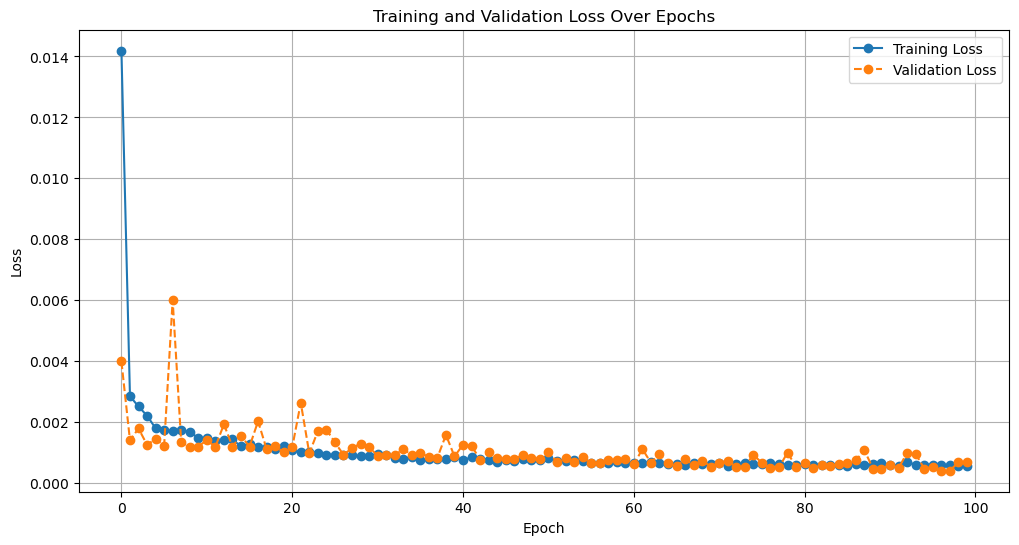

In [66]:
# Access training history
training_loss = history.history['loss']
validation_loss = history.history['val_loss']

# Plot the training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(training_loss, label='Training Loss', marker='o', linestyle='-')
plt.plot(validation_loss, label='Validation Loss', marker='o', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

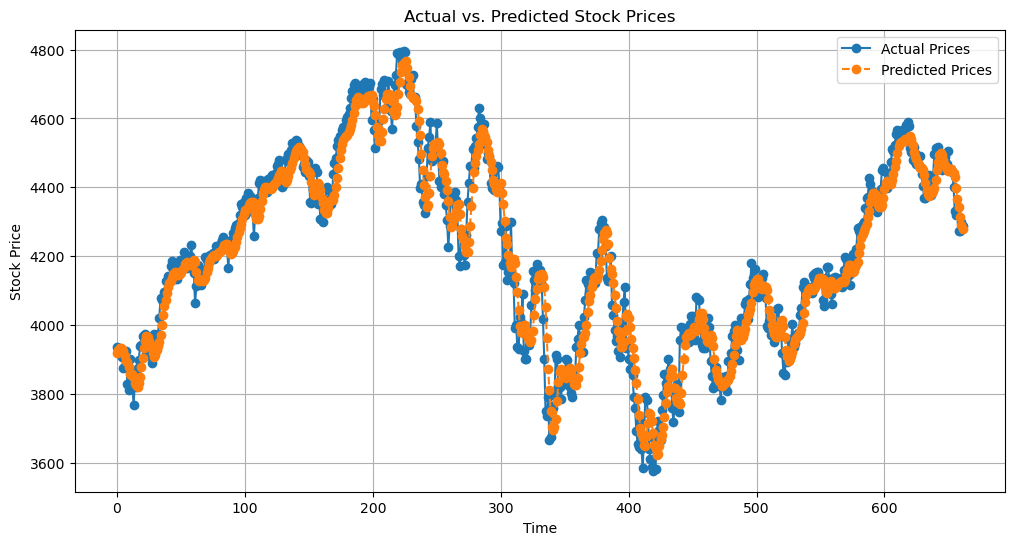

In [67]:
plt.figure(figsize=(12, 6))
plt.plot(test_Y[0], label='Actual Prices', marker='o')
plt.plot(test_predictions[:, 0], label='Predicted Prices', linestyle='--', marker='o')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.title('Actual vs. Predicted Stock Prices')
plt.legend()
plt.grid(True)
plt.show()

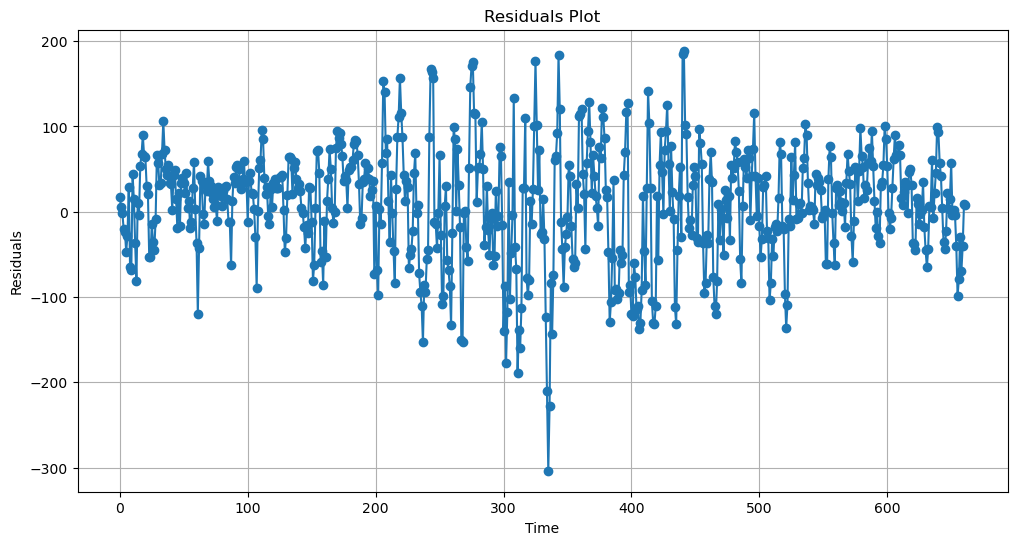

In [ ]:
residuals = test_Y[0] - test_predictions[:, 0]
plt.figure(figsize=(12, 6))
plt.plot(residuals, marker='o')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.title('Residuals Plot')
plt.grid(True)
plt.show()

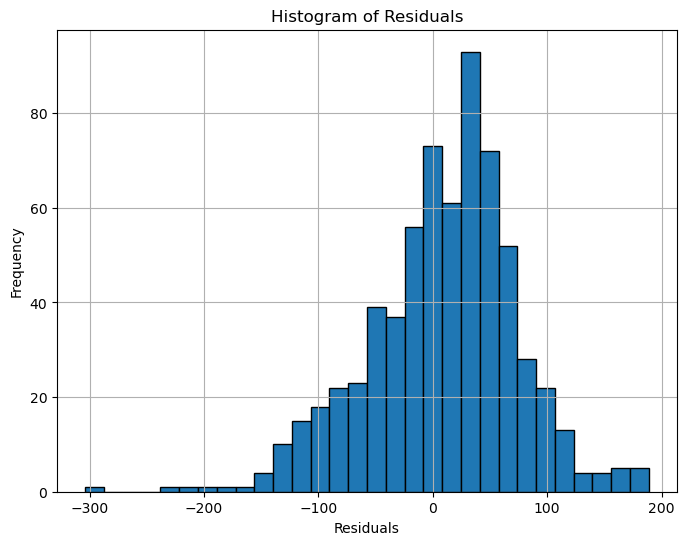

In [69]:
plt.figure(figsize=(8, 6))
plt.hist(residuals, bins=30, edgecolor='k')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.grid(True)
plt.show()

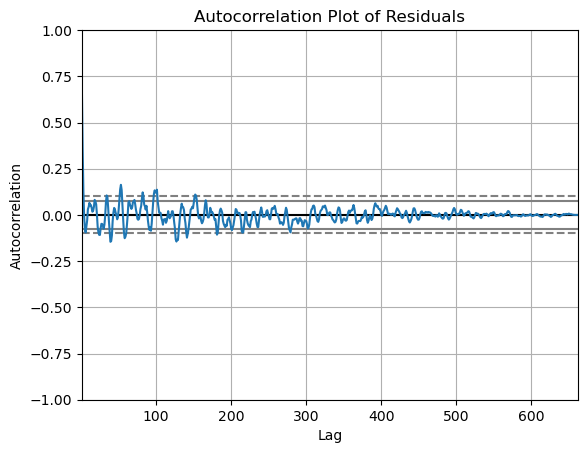

In [70]:
from pandas.plotting import autocorrelation_plot

autocorrelation_plot(pd.Series(residuals))
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation Plot of Residuals')
plt.grid(True)
plt.show()

# LSTM + GRU

In [73]:
# Create and compile the LSTM+GRU model
model_lstm_gru = Sequential()
# LSTM layer
model_lstm_gru.add(LSTM(units=64, return_sequences=True, input_shape=(look_back, 1)))
# GRU layer
model_lstm_gru.add(GRU(units=64))
# Additional layers
model_lstm_gru.add(Dense(units=32, activation='relu'))
model_lstm_gru.add(Dropout(0.2))  # Dropout for regularization
# Output layer
model_lstm_gru.add(Dense(units=1))
# Compile the LSTM+GRU model with custom optimizer (e.g., Adam) and learning rate
optimizer = Adam(learning_rate=0.001)
model_lstm_gru.compile(loss='mean_squared_error', optimizer=optimizer)

In [74]:
# Early stopping and checkpointing
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model_lstm_gru.h5', monitor='val_loss', save_best_only=True)
# Fit the LSTM+GRU model with enhanced parameters
history_lstm_gru = model_lstm_gru.fit(
    train_X,
    train_Y,
    epochs=100,             # You can adjust the number of epochs
    batch_size=64,          # Batch size for training
    validation_split=0.1,   # Use a portion of training data for validation
    callbacks=[early_stopping, checkpoint],
    verbose=2
)

Epoch 1/100
39/39 - 6s - loss: 0.0125 - val_loss: 0.0025 - 6s/epoch - 145ms/step
Epoch 2/100
39/39 - 1s - loss: 0.0030 - val_loss: 0.0013 - 1s/epoch - 32ms/step
Epoch 3/100
39/39 - 1s - loss: 0.0022 - val_loss: 0.0013 - 1s/epoch - 33ms/step
Epoch 4/100
39/39 - 1s - loss: 0.0019 - val_loss: 0.0012 - 1s/epoch - 32ms/step
Epoch 5/100
39/39 - 1s - loss: 0.0019 - val_loss: 9.4764e-04 - 1s/epoch - 32ms/step
Epoch 6/100
39/39 - 1s - loss: 0.0016 - val_loss: 0.0018 - 1s/epoch - 35ms/step
Epoch 7/100
39/39 - 1s - loss: 0.0015 - val_loss: 8.2049e-04 - 1s/epoch - 36ms/step
Epoch 8/100
39/39 - 1s - loss: 0.0015 - val_loss: 0.0011 - 1s/epoch - 37ms/step
Epoch 9/100
39/39 - 1s - loss: 0.0016 - val_loss: 0.0020 - 1s/epoch - 37ms/step
Epoch 10/100
39/39 - 1s - loss: 0.0014 - val_loss: 9.5974e-04 - 1s/epoch - 35ms/step
Epoch 11/100
39/39 - 1s - loss: 0.0015 - val_loss: 0.0011 - 1s/epoch - 34ms/step
Epoch 12/100
39/39 - 1s - loss: 0.0013 - val_loss: 7.7551e-04 - 1s/epoch - 35ms/step
Epoch 13/100
39/39 -

In [76]:
# Load the best LSTM+GRU model weights
model_lstm_gru.load_weights('best_model_lstm_gru.h5')

# Make predictions on the test data using the LSTM+GRU model
test_predictions_lstm_gru = model_lstm_gru.predict(test_X)

# Inverse transform the predictions and actual values to the original scale
test_predictions_lstm_gru = scaler.inverse_transform(test_predictions_lstm_gru)

# Calculate evaluation metrics for the LSTM+GRU model
mae_lstm_gru = mean_absolute_error(test_Y[0], test_predictions_lstm_gru[:, 0])
mse_lstm_gru = mean_squared_error(test_Y[0], test_predictions_lstm_gru[:, 0])
rmse_lstm_gru = math.sqrt(mse_lstm_gru)

print(f'LSTM+GRU Model:')
print(f'Mean Absolute Error (MAE): {mae_lstm_gru:.2f}')
print(f'Mean Squared Error (MSE): {mse_lstm_gru:.2f}')
print(f'Root Mean Squared Error (RMSE): {rmse_lstm_gru:.2f}')

21/21 [==============================] - 0s 7ms/step
LSTM+GRU Model:
Mean Absolute Error (MAE): 53.06
Mean Squared Error (MSE): 5025.56
Root Mean Squared Error (RMSE): 70.89


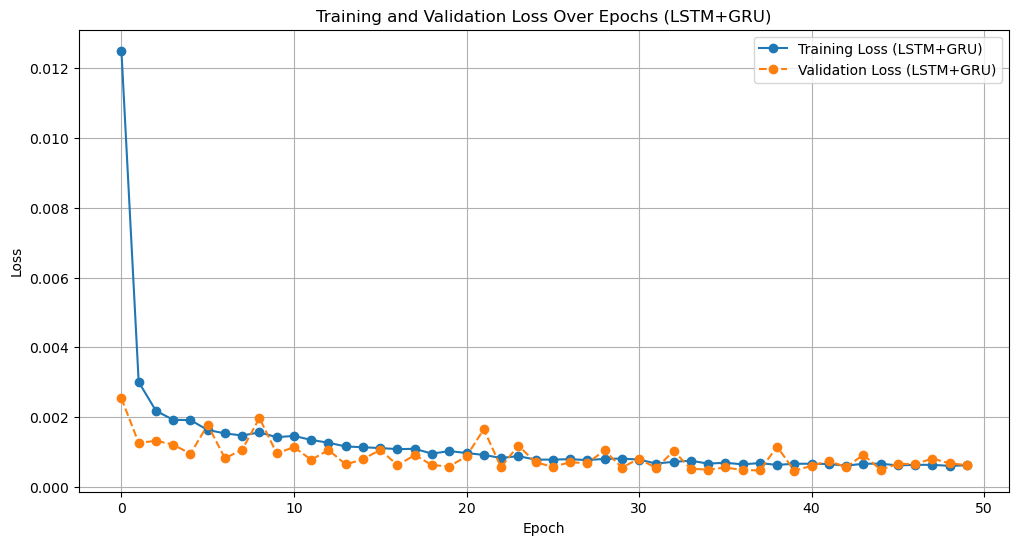

In [77]:
# Plot the training and validation loss for the LSTM+GRU model
plt.figure(figsize=(12, 6))
plt.plot(history_lstm_gru.history['loss'], label='Training Loss (LSTM+GRU)', marker='o', linestyle='-')
plt.plot(history_lstm_gru.history['val_loss'], label='Validation Loss (LSTM+GRU)', marker='o', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs (LSTM+GRU)')
plt.legend()
plt.grid(True)
plt.show()

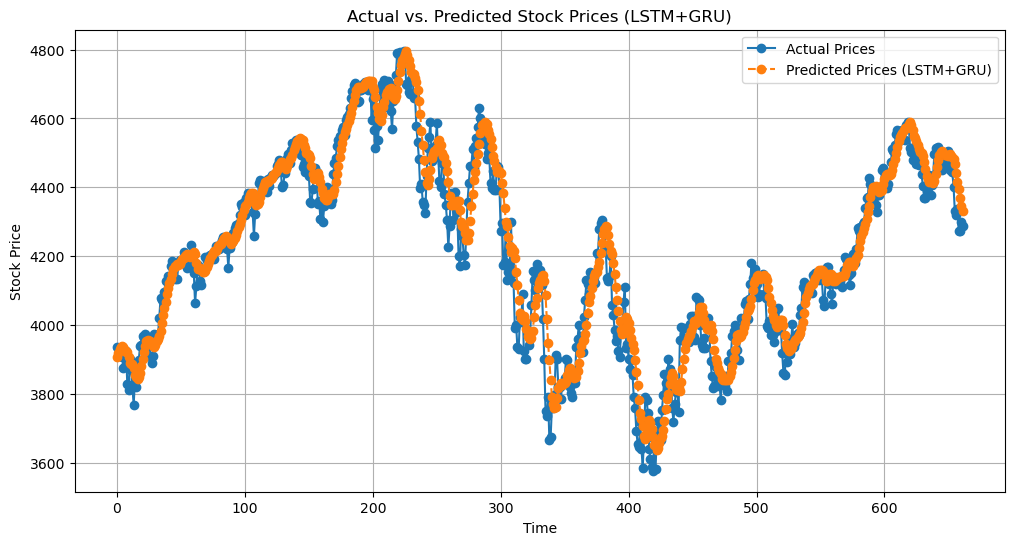

In [78]:
# Plot the actual vs. predicted prices for the LSTM+GRU model
plt.figure(figsize=(12, 6))
plt.plot(test_Y[0], label='Actual Prices', marker='o')
plt.plot(test_predictions_lstm_gru[:, 0], label='Predicted Prices (LSTM+GRU)', linestyle='--', marker='o')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.title('Actual vs. Predicted Stock Prices (LSTM+GRU)')
plt.legend()
plt.grid(True)
plt.show()

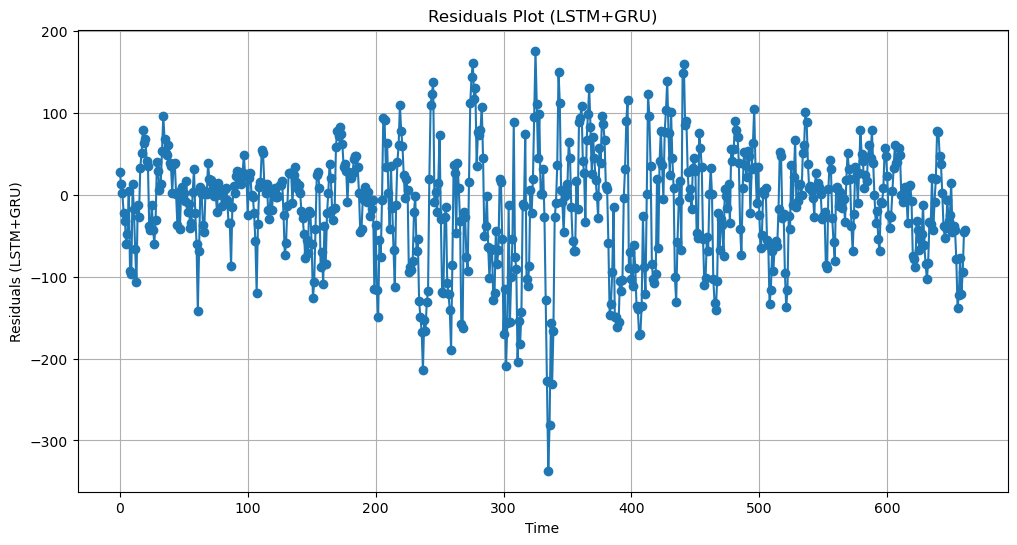

In [79]:
residuals_lstm_gru = test_Y[0] - test_predictions_lstm_gru[:, 0]
plt.figure(figsize=(12, 6))
plt.plot(residuals_lstm_gru, marker='o')
plt.xlabel('Time')
plt.ylabel('Residuals (LSTM+GRU)')
plt.title('Residuals Plot (LSTM+GRU)')
plt.grid(True)
plt.show()

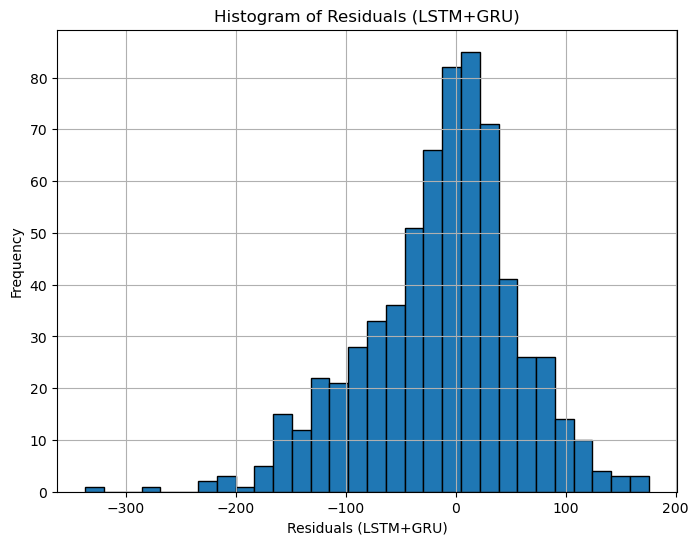

In [80]:
plt.figure(figsize=(8, 6))
plt.hist(residuals_lstm_gru, bins=30, edgecolor='k')
plt.xlabel('Residuals (LSTM+GRU)')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals (LSTM+GRU)')
plt.grid(True)
plt.show()

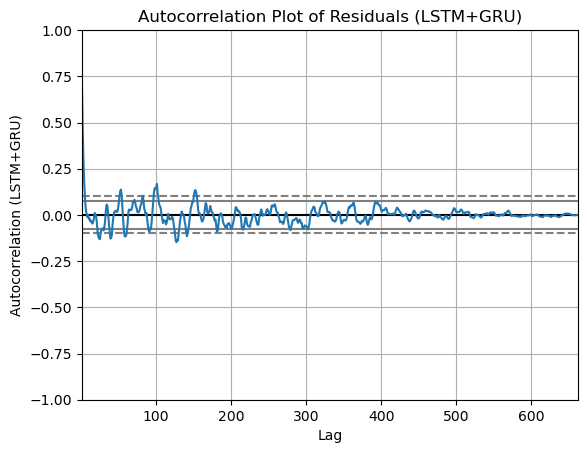

In [81]:
autocorrelation_plot(pd.Series(residuals_lstm_gru))
plt.xlabel('Lag')
plt.ylabel('Autocorrelation (LSTM+GRU)')
plt.title('Autocorrelation Plot of Residuals (LSTM+GRU)')
plt.grid(True)
plt.show()

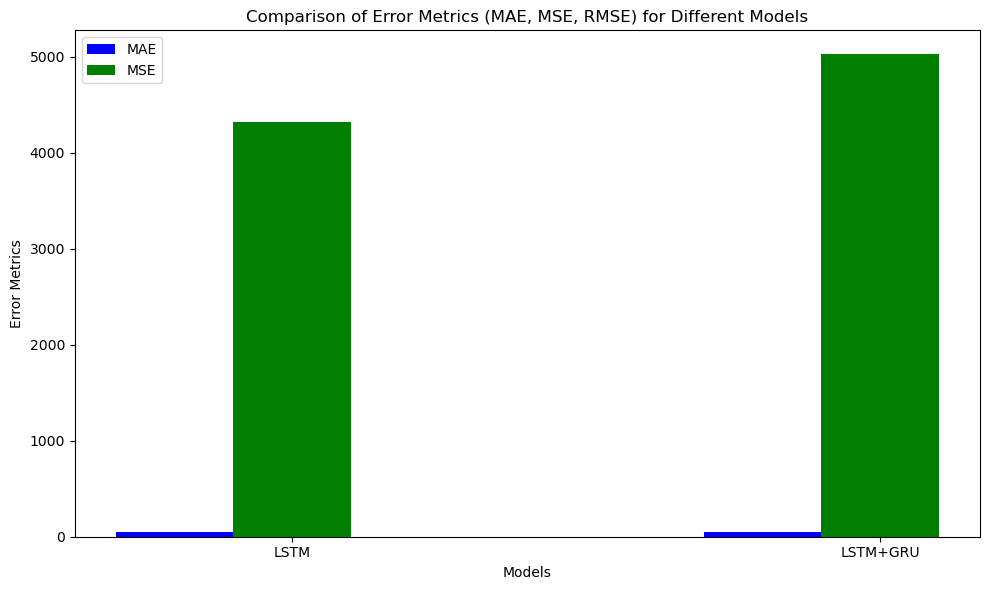

In [85]:
models = ['LSTM', 'LSTM+GRU']
mae_values = [mae, mae_lstm_gru]
mse_values = [mse, mse_lstm_gru]
rmse_values = [rmse, rmse_lstm_gru]

# Set the width of the bars
bar_width = 0.2

# Set the positions for the bars on the x-axis
index = range(len(models))

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Create grouped bar plots for MAE, MSE, and RMSE
bar1 = ax.bar(index, mae_values, bar_width, label='MAE', color='b', align='center')
bar2 = ax.bar([i + bar_width for i in index], mse_values, bar_width, label='MSE', color='g', align='center')

# Set labels, title, and legend
ax.set_xlabel('Models')
ax.set_ylabel('Error Metrics')
ax.set_title('Comparison of Error Metrics (MAE, MSE, RMSE) for Different Models')
ax.set_xticks([i + bar_width for i in index])
ax.set_xticklabels(models)
ax.legend()

# Display the plot
plt.tight_layout()
plt.show()

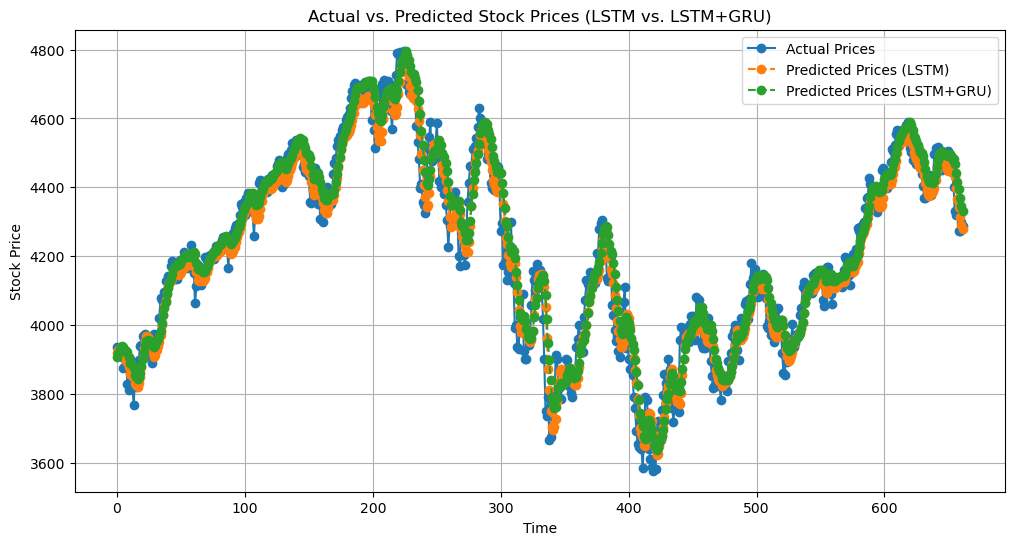

In [86]:
# Plot actual vs. predicted stock prices for both models
plt.figure(figsize=(12, 6))
plt.plot(test_Y[0], label='Actual Prices', marker='o')
plt.plot(test_predictions[:, 0], label='Predicted Prices (LSTM)', linestyle='--', marker='o')
plt.plot(test_predictions_lstm_gru[:, 0], label='Predicted Prices (LSTM+GRU)', linestyle='--', marker='o')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.title('Actual vs. Predicted Stock Prices (LSTM vs. LSTM+GRU)')
plt.legend()
plt.grid(True)
plt.show()